---
title: "Conjunto de modelos"
date: 2022-04-20T10:37:29+02:00
tags: [ensemble models, bagging, bootstrap, boosting, random forest, gradient-boosting,]
categories: [tutoriales]
---

En este post veremos en detalle los algoritmos que combinan varios modelos juntos, también llamados conjunto de modelos. Presentaremos dos familias de estas técnicas: (i) basados en *bootstrapping* y (ii) basados en *boosting*. Presentaremos *bagging* y *árboles aleatorios* como pertenecientes a la primera estrategia y *AdaBoost* y *árboles de decisión gradient boosting* que pertenecen a la última estrategia. Finalmente, hablaremos sobre los hiperparámetros que permiten afinar estos modelos y compararlos entre modelos.

# Ejemplo introductorio a los modelos de conjunto

En este ejemplo queremos enfatizar los beneficios de los métodos de conjunto sobre los modelos simples (por ejemplo, árbol de decisión, modelo lineal, etc.). Combinar modelos simples produce modelos más poderosos y robustos con menos problemas.

Empezaremos cargando el dataset de propiedades de California. El objetivo de este dataset es prededir el valor medio de la vivienda en algunos distritos de California basándonos en datos geofráficos y demográficos.

In [1]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(as_frame=True, return_X_y=True)
y *= 100  # reescala el objetivo en k$

Vamos a comprobar el rendimiento de generalización de un árbol de decisión regresor con los parámetros por defecto.

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)
cv_results = cross_validate(tree, X, y, n_jobs=-1)
scores = cv_results["test_score"]

print(f"Puntuación R2 obtenida por validación cruzada: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

Puntuación R2 obtenida por validación cruzada: 0.354 +/- 0.087


Obtenemos resultados justos. Sin embargo, ya sabemos que este modelo necesita se afinado. De hecho, los parámetros por defecto no conducen necesariamente a un árbol de decisión óptimo. En lugar de usar los valores por defecto, debemos buscar a través de validación cruzada el valor óptimo de parámetros importantes, como son `max_depth`, `min_samples_split` o `min_samples_leaf`.

Recordemos que necesitamos ajustar esos parámetros, ya que los árboles de decisión adolecen de overfitting si aumenta la profundidad del árbol, pero no existen reglas de cómo se debe configurar cada parámetro. Por tanto, no realizar una búsqueda nos llevaría a tener un modelo con underfitting u overfitting.

Ahora vamos a hacer un grid search para afinar los hiperparámetros que hemos mencionado anteriormente.

In [3]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
      "max_depth": [5, 8, None],
      "min_samples_split": [2, 10, 30, 50],
      "min_samples_leaf": [0.01, 0.05, 0.1, 1]}
cv = 3

tree = GridSearchCV(DecisionTreeRegressor(random_state=0),
                    param_grid=param_grid, cv=cv, n_jobs=-1)
cv_results = cross_validate(tree, X, y, n_jobs=-1,
                            return_estimator=True)
scores = cv_results["test_score"]

print(f"Puntuación R2 obtenida por validación cruzada: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

Puntuación R2 obtenida por validación cruzada: 0.523 +/- 0.107
CPU times: total: 46.9 ms
Wall time: 4.23 s


Vemos que optimizar los hiperparámetros tiene un efecto positivo en el rendimiento de generalización. Sin embargo, conlleva un alto coste computacional.

Podemos crear un dataframe almacenando la información importante recopilada durante el ajuste de hiperparámetros e investigar los resultados.

Ahora usaremos un metodo de conjunto llamado **bagging**. Brevemente, este método usará un regresor de base (es decir, árboles de decisión regresores) y entrenará varios de ellos en una versión ligeramente modificada del conjunto de entrenamiento. Luego, las predicciones de todos esos regresores base se combinarán promediando.

Aquí, usaremos 20 árboles de decisión y comprobaremos el tiempo de entrenamiento así como el rendimiento de generalización en los datos de prueba externos. Es importante notar que no vamos a ajustar ningún parámetro del árbol de decisión.

In [4]:
%%time
from sklearn.ensemble import BaggingRegressor

base_estimator = DecisionTreeRegressor(random_state=0)
bagging_regressor = BaggingRegressor(
    base_estimator=base_estimator, n_estimators=20, random_state=0)

cv_results = cross_validate(bagging_regressor, X, y, n_jobs=-1)
scores = cv_results["test_score"]

print(f"Puntuación R2 obtenida por validación cruzada: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

Puntuación R2 obtenida por validación cruzada: 0.642 +/- 0.083
CPU times: total: 62.5 ms
Wall time: 3.53 s


Sin realizar la búsqueda de los hiperparámetros óptimos, el rendimiento de generalización global del regresor bagging es mucho mejor que un único árbol de decisión. Además, el coste computacional se reduce en comparación a la búsqueda de hiperparámetros óptimos.

Esto muestra la motivación existente detrás del uso de métodos de conjunto: proporcionan una relativamente buena baseline con un rendimiento de generalización decente sin ningún ajuste de hiperparámetros.

A continuación veremos en detalle dos familias de conjunto: bagging y boosting:

+ conjunto usando bootstrap (por ejemplo, bagging y bosques aleatorios);
+ conjunto usando boosting (por ejemplo, boosting adaptativo y álboles de decisión gradient-boosting).

# Métodos de conjuntos usando bootstrapping

## Bagging

Vamos a introducir una estrategia muy natural de construir conjuntos de modelos de machine learning llamado "bagging".

"Bagging" proviene de Bootstrap AGGregatING. Utiliza remuestreo bootstrap (muestreo aleatorio con reemplazo) para aprender varios modelos en variaciones aleatorias del conjunto de entrenamiento. A la hora de predecir, se agregan las predicciones de cada aprendiz para obtener las predicciones finales.

En primer lugar, vamos a generar un dataset sintético simple para obtener información de bootstraping.

In [5]:
import pandas as pd
import numpy as np

rng = np.random.RandomState(1)

def generate_data(n_samples=30):
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

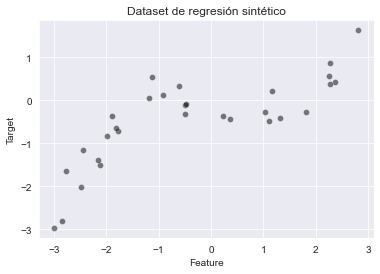

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train = generate_data(n_samples=30)
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
_ = plt.title("Dataset de regresión sintético")

La relación entre nuestras features y el objetivo a predecir es no lineal. Sin embargo, un árbol de decisión es capaz de aproximar tal dependencia no lineal:

In [7]:
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

En este caso, el término "test" se refiere a datos que no se han usado previamente para entrenar y calcular una métrica de evaluación en un conjunto de prueba de este tipo no tendría sentido.

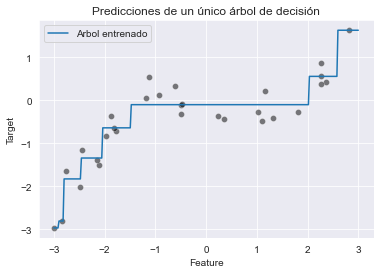

In [8]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
plt.plot(X_test["Feature"], y_pred, label="Arbol entrenado")
plt.legend()
_ = plt.title("Predicciones de un único árbol de decisión")

Veamos cómo podemos usar bottstraping para aprender varios árboles.

### Bootstrap resampling

Una muestra bootstrap corresponde a un remuestreo con reemplazo del dataset original, una muestra que tiene el mismo tamaño que el dataset original. Por lo tanto, la muestra bootstrap contendrá varias veces algunos puntos de datos, mientras que algunos de los puntos de datos originales no estarán presentes.

Crearemos una función que, dados `X` e `y`, devolverá una variación remuestreada `X_boostrap` e `y_boostrap`.

In [9]:
def bootstrap_sample(data, target):
    # indices corresponde a un muestreo con reemplazo del misma tamaño de muestra
    # que los datos originales
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]), size=target.shape[0], replace=True,
    )
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

Vamos a generar 3 muestras bootstrap y verificaremos cualitativamente la diferencia con el dataset original.

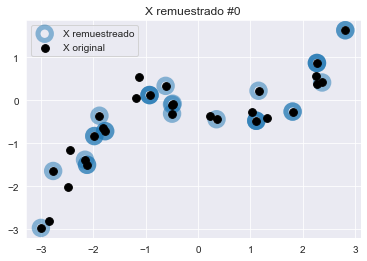

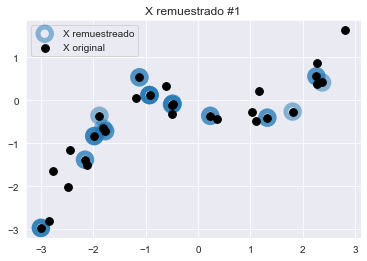

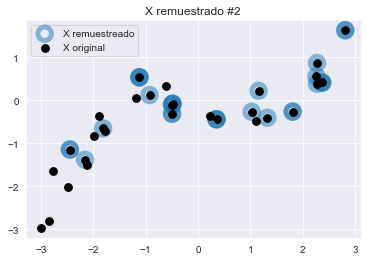

In [10]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    X_bootstrap, y_bootstrap = bootstrap_sample(
        X_train, y_train
    )
    plt.figure()
    plt.scatter(X_bootstrap["Feature"], y_bootstrap,
                color="tab:blue", facecolor="none",
                alpha=0.5, label="X remuestreado", s=180, linewidth=5)
    plt.scatter(X_train["Feature"], y_train,
                color="black", label="X original", s=60)
    plt.title(f"X remuestrado #{bootstrap_idx}")
    plt.legend()

Observemos que las tres variaciones comparten puntos comunes con el dataset original. Algunos puntos son remuestreados aleatoriamente varias veces y aparecen como círculos azul oscuro.

Las tres muestras bootstrap generadas son diferentes del dataset original y entre cada una de ellas. Para confirmar esta intuición, podemos comprobar el número de muestras únicas en las muestras bootstrap.

In [11]:
X_train_huge, X_test_huge, y_train_huge = generate_data(n_samples=100_000)
X_bootstrap_sample, y_bootstrap_sample = bootstrap_sample(
    X_train_huge, y_train_huge)

ratio_unique_sample = (np.unique(X_bootstrap_sample).size /
                       X_bootstrap_sample.size)
print(
    f"Porcentaje de muestras presentes en el dataset original: "
    f"{ratio_unique_sample * 100:.1f}%"
)

Porcentaje de muestras presentes en el dataset original: 63.2%


En promedio, un 63.2% de los puntos de datos del dataset original estarán presentes en una muestra bootstrap dada. El otro 36.8% son muestras repetidas. Somos capaces de generar muchos datasets, todos ligeramente diferentes.

Ahora podemos entrenar un árbol de decisión para cada uno de esos datasets y todos ellos serán también ligeramente diferentes.

In [12]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)

    X_bootstrap_sample, y_bootstrap_sample = bootstrap_sample(
        X_train, y_train)
    tree.fit(X_bootstrap_sample, y_bootstrap_sample)
    bag_of_trees.append(tree)

Ahora que podemos crear una bolsa de árboles diferentes, podemos usar cada uno de los tres árboles para predecir las muestras dentro del rango de los datos. Ellos proporcionarán predicciones ligeramente diferentes.

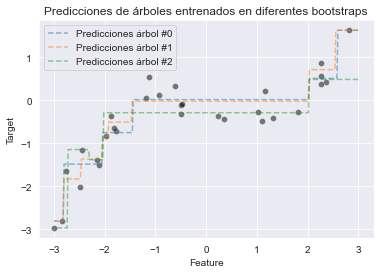

In [13]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
for tree_idx, tree in enumerate(bag_of_trees):
    y_pred = tree.predict(X_test)
    plt.plot(X_test["Feature"], y_pred, linestyle="--", alpha=0.5,
             label=f"Predicciones árbol #{tree_idx}")
plt.legend()
_ = plt.title("Predicciones de árboles entrenados en diferentes bootstraps")

### Agregación

Una vez hemos entrenado nuestros árboles somos capaces de obtener predicciones de cada uno de ellos. En regresión, la forma más directa de combinar esas predicciones es promediarlas:para un punto de datos de prueba dado, alimentamos los valores de features de entrada a cada uno de los `n` models entrenados en el conjunto y, como resultado, calculamos `n` valores predichos para la variable objetivo. La predicción final del conjunto para los puntos de datos de prueba es la media de esos `n`valores.

Podemos dibujar las predicciones promediadas del ejemplo anterior.

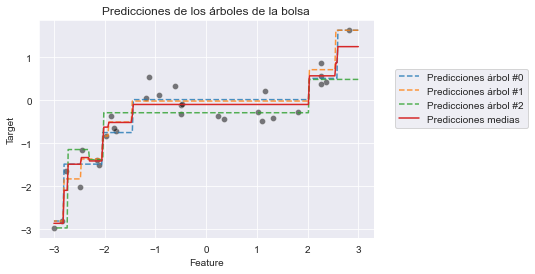

In [14]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

bag_predictions = []
for tree_idx, tree in enumerate(bag_of_trees):
    y_pred = tree.predict(X_test)
    plt.plot(X_test["Feature"], y_pred, linestyle="--", alpha=0.8,
             label=f"Predicciones árbol #{tree_idx}")
    bag_predictions.append(y_pred)

bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(X_test["Feature"], bag_predictions, label="Predicciones medias",
         linestyle="-")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predicciones de los árboles de la bolsa")

La línea roja continua muestras las predicciones medias, las cuales serán las predicciones finales proporcionadas por nuestra bolsa de árboles de decisión regresores. Nótese que las predicciones de los conjuntos son más estables debido a la operación de promedio. Como resultado, el conjunto de árboles, en global, es menos probable que adolezca de overfitting que los árboles individuales.

### Bagging en scikit-learn

Scikit-learn implementa el procedimiento de bagging como un "meta-estimador", que es un estimador que recubre otro estimador: toma un modelo base que es clonado varias veces y entrenado independientemente en cada muestra bootstrap.

El siguiente fragmento de código muestra cómo construir un conjunto bagging de árboles de decisión. Establecemos `n_estimators=100` en lugar de los 3 que vimos anteriormente en la implementación manual para obtener un efecto de suavizado más fuerte.

In [15]:
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100
)
bagged_trees.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                 n_estimators=100)

Vamos a visualizar las predicciones del conjunto en el mismo intervalo de datos:

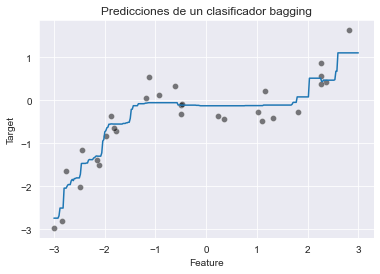

In [16]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

y_pred = bagged_trees.predict(X_test)
plt.plot(X_test["Feature"], y_pred)
_ = plt.title("Predicciones de un clasificador bagging")

Debido a que hemos usado 100 árboles en el conjunto, las predicción media es ligeramente más suave pero muy similar a la del gráfico anterior. Es posible acceder después del entrenamiento a los modelos internos del conjunto almacenados como una lista de Python en el atributo `bagged_trees.estimators_`.

Comparemos las predicciones de los modelos base con sus medias:

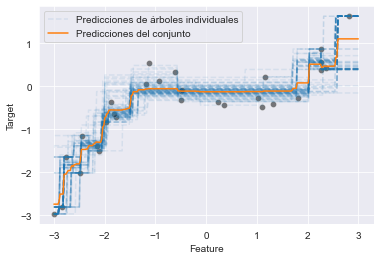

In [17]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predicciones de árboles individuales" if tree_idx == 0 else None
    # convertirmos `X_test` a un array Numpy para evitar el warning de scikit-learn
    y_pred = tree.predict(X_test.to_numpy())
    plt.plot(X_test["Feature"], y_pred, linestyle="--", alpha=0.1,
             color="tab:blue", label=label)

sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

y_pred = bagged_trees.predict(X_test)
plt.plot(X_test["Feature"], y_pred,
         color="tab:orange", label="Predicciones del conjunto")
_ = plt.legend()

Usamos un valor bajo del parámetro de opacidad `alpha` para apreciar mejor el solape en las funciones de predicción de los árboles individuales.

Esta visualización nos da algunas ideas sobre la incertidumbre de las predicciones en diferentes áreas del espacio de features.

### Pipelines de bagging complejos

Aunque hemos usado un árbol de decisión como modelo de base, nada nos impide que usemos cualquier otro tipo de modelo.

Como sabemos que la función de generación de los datos originales es una transformación polinomial ruidosa de la variable de entrada, intentemos entrenar un pipeline de regresión polinomial bagged en este dataset.

In [18]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline

polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10),
)

El pipeline en primer lugar escala los datos a un rango 0-1 con `MinMaxScaler`. Despupés extrae features polinomiales de grado 4. Las features resultantes permanecerán en el rango 0-1 por construcción: si `x` se encuentra en el rango 0-1, entonces `x ** n` también se encontrará en el rango 0-1 para cualquier valor de `n`.

Después el pipeline alimenta las features no lineales resultantes a un modelo de regresión lineal regularizado para la predicción final de la variable objetivo.

Nótese que se ha usado intencionadamente un valor pequeño para el parámetro de regularización `alpha`, ya que esperamos que el conjunto bagging funcione bien con modelos de base ligeramente overfitting.

El conjunto en sí mismo se construye simplemente pasando el pipeline resultante al paráemtro `base_estimator` de la clase `BaggingRegressor`:

In [19]:
bagging = BaggingRegressor(
    base_estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0,
)
bagging.fit(X_train, y_train)

BaggingRegressor(base_estimator=Pipeline(steps=[('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('polynomialfeatures',
                                                 PolynomialFeatures(degree=4)),
                                                ('ridge', Ridge(alpha=1e-10))]),
                 n_estimators=100, random_state=0)

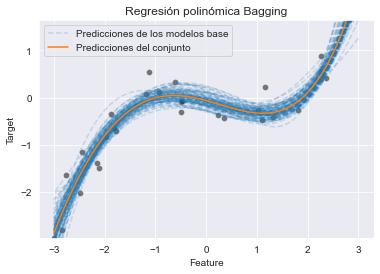

In [20]:
for i, regressor in enumerate(bagging.estimators_):
    # convertirmos `X_test` a un array Numpy para evitar el warning de scikit-learn
    regressor_predictions = regressor.predict(X_test.to_numpy())
    base_model_line = plt.plot(
        X_test["Feature"], regressor_predictions, linestyle="--", alpha=0.2,
        label="Predicciones de los modelos base" if i == 0 else None,
        color="tab:blue"
    )

sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

y_pred = bagging.predict(X_test)
plt.plot(X_test["Feature"], y_pred,
         color="tab:orange", label="Predicciones del conjunto")
plt.ylim(y_train.min(), y_train.max())
plt.legend()
_ = plt.title("Regresión polinómica Bagging")

Las predicciones de este modelo de regresión polinómica bagged parece cualitativamente mejor que los áboles bagging. Esto era algo esperado dado que el modelo de base refleja mejor nuestro conocimiento del proceso de generación de los datos verdaderos.

De nuevo las diferentes opacidades inducidas por el solapamiento de las líneas azules nos permite apreciar la incertidumbre de las predicciones en el conjunto bagged.

Nótese que el procedimiento de bootstrapping es una herramienta genérica de estadística y no está limitada a construir conjuntos de modelos de machine learning. Se puede obtener más detalle sobre este punto en el [artículo de Wikipedia sobre bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)).

### Ejercicio bagging

Vamos a realizar un pequeño ejercicio de lo visto hasta ahora. Queremos investigar si podemos ajustar los hiperparámetros de un regresor bagging y evaluar la ganancia obtenida. Para ello usaremos el dataset de propiedades de California.

In [21]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(as_frame=True, return_X_y=True)
y *= 100  # rescale the target in k$
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.5)

Vamos a crear un `BaggingRegressor` y proporcionaremos un `DecisionTreeRegressor` a su parámetro `base_estimator`. Entrenaremos el regresor y evaluaremos su rendimiento de generalización en el conjunto de prueba usando el error absoluto medio.

In [22]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

bagging = BaggingRegressor(
    base_estimator=DecisionTreeRegressor())

bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

print(f"MAE del regresor bagging básico: "
      f"{mean_absolute_error(y_test, y_pred):.2f} k$")

MAE del regresor bagging básico: 36.81 k$


Ahora crearemos una instancia de `RandomizedSearchCV` usando el modelo previo y ajustando los parámetros importantes del regresor bagging. Debemos encontrar los mejores parámetros y comprobar que somos capaces de encontrar un conjunto de parámetros que mejoren el regresor por defecto, usando también como métrica el error absoluto medio.

In [23]:
# Comprobemos cuáles son los parámetros de nuestro regresor bagging
bagging.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__criterion': 'squared_error',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeRegressor(),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [24]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": randint(10, 30),
    "max_samples": [0.5, 0.8, 1.0],
    "max_features": [0.5, 0.8, 1.0],
    "base_estimator__max_depth": randint(3, 10),
}

model = RandomizedSearchCV(
    bagging, param_grid, n_iter=20, scoring="neg_mean_absolute_error")
model.fit(X_train, y_train)

RandomizedSearchCV(estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor()),
                   n_iter=20,
                   param_distributions={'base_estimator__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BC320121A0>,
                                        'max_features': [0.5, 0.8, 1.0],
                                        'max_samples': [0.5, 0.8, 1.0],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BC31FDFEE0>},
                   scoring='neg_mean_absolute_error')

In [25]:
model.best_params_

{'base_estimator__max_depth': 9,
 'max_features': 0.8,
 'max_samples': 0.8,
 'n_estimators': 18}

In [26]:
import pandas as pd

cv_results = pd.DataFrame(model.cv_results_)
cv_results.sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_max_features,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.385932,0.028178,0.006805,0.000245,9,0.8,0.8,18,"{'base_estimator__max_depth': 9, 'max_features...",-39.806466,-40.840084,-39.645806,-39.236625,-38.822962,-39.670389,0.677288,1
5,0.354704,0.010814,0.007607,0.000664,8,1.0,0.5,20,"{'base_estimator__max_depth': 8, 'max_features...",-41.227987,-41.899496,-41.463204,-43.028313,-38.984266,-41.320653,1.322027,2
15,0.470204,0.029552,0.008808,0.000872,7,1.0,0.5,29,"{'base_estimator__max_depth': 7, 'max_features...",-43.237831,-43.707574,-42.392002,-43.857066,-40.930188,-42.824932,1.076320,3
16,0.217487,0.006142,0.007306,0.002161,7,0.8,0.5,17,"{'base_estimator__max_depth': 7, 'max_features...",-42.748494,-45.077194,-41.964396,-43.444914,-42.310615,-43.109122,1.101284,4
9,0.589306,0.010072,0.008807,0.001505,7,1.0,1.0,23,"{'base_estimator__max_depth': 7, 'max_features...",-43.669015,-44.238697,-42.707257,-44.264421,-40.991116,-43.174101,1.228859,5
11,0.475008,0.022866,0.007306,0.000245,6,0.8,1.0,26,"{'base_estimator__max_depth': 6, 'max_features...",-45.339747,-46.218229,-44.174312,-46.238538,-43.790341,-45.152234,1.016135,6
1,0.349401,0.009797,0.007706,0.001165,6,1.0,0.5,26,"{'base_estimator__max_depth': 6, 'max_features...",-45.733829,-45.975112,-44.769356,-46.034011,-43.303986,-45.163259,1.034884,7
4,0.246113,0.006155,0.006404,0.000201,9,0.5,0.8,18,"{'base_estimator__max_depth': 9, 'max_features...",-42.428941,-48.935587,-46.927217,-45.898861,-48.419120,-46.521945,2.312146,8
2,0.350001,0.013110,0.007708,0.000749,7,0.5,1.0,26,"{'base_estimator__max_depth': 7, 'max_features...",-46.870118,-47.303842,-47.751741,-47.484000,-45.231304,-46.928201,0.895664,9
13,0.313569,0.018326,0.006605,0.000970,5,0.8,1.0,21,"{'base_estimator__max_depth': 5, 'max_features...",-49.405238,-49.406031,-47.595204,-48.568605,-47.921095,-48.579235,0.743969,10


In [27]:
y_pred = model.predict(X_test)

print(f"MAE del regresor bagging tuneado: "
      f"{mean_absolute_error(y_test, y_pred):.2f} k$")

MAE del regresor bagging tuneado: 38.58 k$


Podemos ver que el predictor proporcionado por el regresor bagging no necesita de demasiado ajuste de hiperparámetros. No se consigue mejora con el tuneado.

## Bosque aleatorio

Vamos a presentar los modelos random forest y mostraremos las diferencias con los conjuntos bagging. Random forest es un modelo popular en machine learning. Es una modificación del algoritmo bagging. En bagging, se puede usar cualquier clasificador o regresor. En random forest, el clasificador o regresor base es siempre un árbol de decisión.

Random forest tiene otra particularidad: cuando se entrena un árbol, la búsqueda de la mejor división se realiza solo en un subconjunto de las features originales tomadas al azar. Los subconjuntos aleatorios son diferentes para cada división de nodo. El objetivo es inyectar aleatoriedad adicional en el procedimiento de aprendizaje para intentar decorrelacionar los errores predichos de los árboles individuales.

Por tanto, random forest usan aleatoriedad en ambos ejes de la matriz de datos:

+ en las muestras bootstrapping de cada árbol del bosque;
+ seleccionando aleatoriamente un subconjunto de features en cada nodo del árbol.


### Un vistazo a random forests

Ilustraremos el uso de un clasificador random forest en el dataset de censo de adultos.

In [28]:
adult_census = pd.read_csv("../data/adult_census.csv")
target_name = "class"
X = adult_census.drop(columns=[target_name, "education-num"])
y = adult_census[target_name]

El dataset de censo de adultos contiene algunas datos categóricos y codificaremos las variables categóricas usando un `OrdinalEncoder`, dado que los modelos basados en árbol pueden trabajan muy eficientemente con esta representación tan simple de variables categóricas.

Dado que existen categorías raras en este dataset necesitamos especificar la codificación de las categorías desconocidas en tiempo de predicción para que sea capaz de usar validación cruzada. De lo contrario, algunas categorías raras solo podrían estar presentes en el lado de validación de la división de validación cruzada y `OrdinalEncoder` podría lanzar un error cuando llame a su método `transform` con los puntos de datos del conjunto de validación.

In [29]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

categorial_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = make_column_transformer(
    (categorial_encoder, make_column_selector(dtype_include=object)),
    remainder="passthrough"
)

Haremos primero un ejemplo simple donde entrenaremos un único clasificador de árbol de decisión y comprobaremos su rendimiento de generalización a través de validación cruzada.

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

tree = make_pipeline(preprocessor,
                     DecisionTreeClassifier(random_state=0))

In [31]:
from sklearn.model_selection import cross_val_score

scores_tree = cross_val_score(tree, X, y)

print(f"Clasificador árbol decisión: "
      f"{scores_tree.mean():.3f} +/- {scores_tree.std():.3f}")

Clasificador árbol decisión: 0.812 +/- 0.002


De forma similar a como hemos hecho anteriormente, vamos a construir un `BaggingClassifier` con un clasificador de árbol de decisión como modelo base. Además, necesitamos especificar cuántos modelos queremos combinar. También necesitamos preprocesar los datos y, por tanto, usaremos un pipeline de scikit-learn.

In [32]:
from sklearn.ensemble import BaggingClassifier

bagged_trees = make_pipeline(
    preprocessor,
    BaggingClassifier(
        base_estimator=DecisionTreeClassifier(random_state=0),
        n_estimators=50, n_jobs=-1, random_state=0
    )
)

In [33]:
scores_bagged_trees = cross_val_score(bagged_trees, X, y)

print(f"Clasificador arbol decisión bagged: "
      f"{scores_bagged_trees.mean():.3f} +/- "
      f"{scores_bagged_trees.std():.3f}")

Clasificador arbol decisión bagged: 0.853 +/- 0.003


El rendimiento de generalización de los árboles bagged es mucho mejor que el rendimiento de un único árbol.

Ahora vamos a usar random forest. Observaremos que no necesitamos especificar ningún `base_estimator` porque el estimador se fuerza que sea un árbol de decisión. Por tanto, sólo necesitamos especificar el número deseado de árboles del bosque.

In [34]:
from sklearn.ensemble import RandomForestClassifier

random_forest = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=0)
)

In [35]:
scores_random_forest = cross_val_score(random_forest, X, y)

print(f"Clasificador random forest: "
      f"{scores_random_forest.mean():.3f} +/- "
      f"{scores_random_forest.std():.3f}")

Clasificador random forest: 0.856 +/- 0.002


Parece que el rendimiento de random forest es ligeramente superior a los árboles bagged, posiblemente debido a la selección aleatoria de las variables que decorrelacionan los errores de predicción de los árboles individuales y, en consecuencia, hacen el paso de promediado más eficiente al reducir el overfitting.

### Detalles sobre los hiperparámetros por defecto

Para random forest es posible controlar la cantidad de aleatoriedad para cada división estableciendo el valor del hiperparámetro `max_features`:

+ `max_features=0-5` significa que se considerarán el 50% de las features en cada división;
+ `max_features=1.0` significa que se considerarán todas las features en cada división, lo que realmente deshabilita el submuestreo de features.

Por defecto, `RandomForestRegressor` deshabilita el submuestreo de features mientras que `RandomForestClassifier` usa `max_features=np.sqrt(n_features)`. Estos valores por defecto reflejan buenas prácticas dadas en la literatura científica.

Sin embargo, `max_features` es uno de los hiperparámetros a tener en consideración cuando se ajusta un random forest:

+ demasiada aleatoriedad en los árboles puede conducir a modelos base con underfitting y puede ir en detrimento del conjunto en su totalidad,
+ muy poca aleatoriedad en los árboles conduce a mayor correlación de los errores de predicción y, como resultado, a reducir los beneficios del paso de promediado en términos de control del overfitting.

En scikit-learn, las clases bagging también exponen un parámetro `max_features`. Sin embargo, `BaggingClassifier` y `BaggingRegressor` son agnósticos respecto al sus modelos base y, por tanto, el submuestro de features aleatorio solo puede producirse una vez antes de entrenar cada modelo base, en lugar de varias veces por modelo base como es el caso cuando se añaden divisiones a un árbol dado.

Se pueden resumir estos detalles en la siguiente tabla:

| Clase modelo de conjunto | Clase modelo base                   | Valor por defecto para `max_features` | Estrategia de submuestreo de features |
|--------------------------|-------------------------------------|---------------------------------------|---------------------------------------|
| `BaggingClassifier`      | especificado por usuario (flexible) | `n_features` (sin submuestreo)        | Nivel de modelo                       |
| `RandomForestClassifier` | `DecisionTreeClassifier`            | `sqrt(n_features)`                    | Nivel de nodo de árbol                |
| `BaggingRegressor`       | especificado por usuario (flexible) | `n_features` (sin submuestreo)    | Nivel de modelo                       |
| `RandomForestRegressor`  | `DecisionTreeRegressor`             | `n_features` (sin submuestreo)    | Nivel de nodo de árbol                |

### Ejercicio random forest

Vamos a realizar un pequeño ejercicio de random forest. El objetivo es explorar algunos atributos disponibles en random forest de scikit-learn. Vamos a usar el dataset de regresión de pingüinos.

In [36]:
from sklearn.model_selection import train_test_split

penguins = pd.read_csv("../data/penguins_regression.csv")
feature_name = "Flipper Length (mm)"
target_name = "Body Mass (g)"
X, y = penguins[[feature_name]], penguins[target_name]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

Crearemos un random forest conteniendo 3 árboles. Entrenaremos el bosque y comprobaremos el rendimiento de generalización en el conjunto de prueba en términos de error absoluto medio.

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

random_forest = RandomForestRegressor(n_estimators=3, n_jobs=-1,
                                      random_state=0)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f} g")

MAE: 345.349 g


Lo siguiente que haremos será:

+ crear un dataset que contenga los pinguinos con un tamaño de aleta entre 170 mm y 230 mm,
+ dibujar los datos de entrenamiento usando un scatter plot,
+ dibujar la decisión de cada árbol individual prediciendo en el recién creado dataset,
+ dibujar la decisión del random forest usando este recién creado dataset.

In [38]:
data_range = pd.DataFrame(np.linspace(170, 235, num=300),
                          columns=X.columns)
tree_preds = []
for tree in random_forest.estimators_:
    tree_preds.append(tree.predict(data_range.to_numpy()))

random_forest_preds = random_forest.predict(data_range)

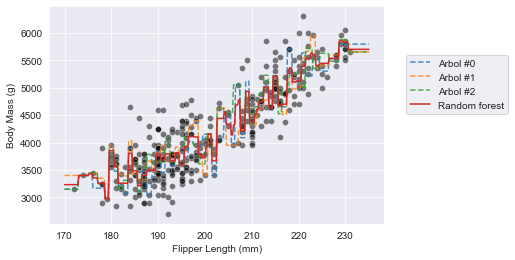

In [39]:
sns.scatterplot(data=penguins, x=feature_name, y=target_name,
                color="black", alpha=0.5)

# Dibuja las predicciones de los árboles
for tree_idx, predictions in enumerate(tree_preds):
    plt.plot(data_range[feature_name], predictions, label=f"Arbol #{tree_idx}",
             linestyle="--", alpha=0.8)

plt.plot(data_range[feature_name], random_forest_preds, label=f"Random forest")
_ = plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")

# Conjuntos basados en boosting

## Boosting adaptativo (AdaBoost)

Vamos a presentar el algoritmos Boosting Adaptativo (AdaBoost). El objetivo es obtener información observando la maquinaria interna de AdaBoots y boosting en general.

Cargaremos el dataset de pingüinos y predeciremos su especie a partir de las features de longitud y anchura del pico.

In [40]:
penguins = pd.read_csv("../data/penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"
X, y = penguins[culmen_columns], penguins[target_column]

Entrenaremos un árbol de decisión poco profundo intencionadamente. Dada su poca profundidad, es poco probable que tenga overfitting y algunas de las muestras de entrenamiento incluso serán mal clasificadas.

In [41]:
from sklearn.tree import DecisionTreeClassifier

palette = ["tab:red", "tab:blue", "black"]

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=0)

Podemos predecir en el mismo dataset y comprobar qué muestras están mal clasificadas.

In [42]:
y_pred = tree.predict(X)
misclassified_samples_idx = np.flatnonzero(y != y_pred)
X_misclassified = X.iloc[misclassified_samples_idx]

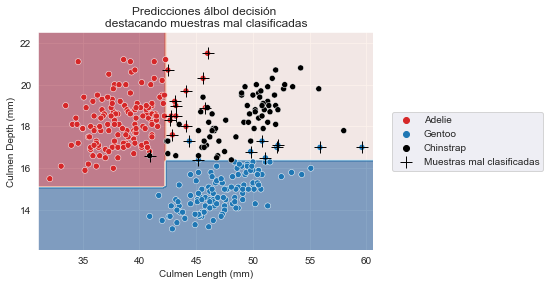

In [43]:
from helpers.plotting import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(
    tree, X, response_method="predict", cmap="RdBu", alpha=0.5
)

# dibuja el dataset original
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
# Dibuja los ejemplos mal clasificados
sns.scatterplot(data=X_misclassified, x=culmen_columns[0],
                y=culmen_columns[1], label="Muestras mal clasificadas",
                marker="+", s=150, color="k")

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Predicciones álbol decisión \ndestacando muestras mal "
              "clasificadas")

Observamos que hay varios ejemplos que han sido mal clasificados por el clasificador.

Mencionamos que boosting se basa en la creación de un nuevo clasificador que intenta corregir esas clasificaciones erróneas. En scikit-learn, los aprendices tiene un parámetro `sample_weight` que fuerza a prestar más atención a los ejemplos con pesos altos durante el entrenamiento.

Este parámetro se establece cuando se llama a `classifier.fit(X, y, sample_weight=weights)`. Usaremos este truco para crear un nuevo clasificador "descartando" todas las muestras clasificadas correctamente y considerando únicamente las mal clasificadas. Así, a las muestras mal clasificadas se asigará un peso de 1 y a las bien clasificadas un peso de 0.

In [44]:
sample_weight = np.zeros_like(y, dtype=int)
sample_weight[misclassified_samples_idx] = 1

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(X, y, sample_weight=sample_weight)

DecisionTreeClassifier(max_depth=2, random_state=0)

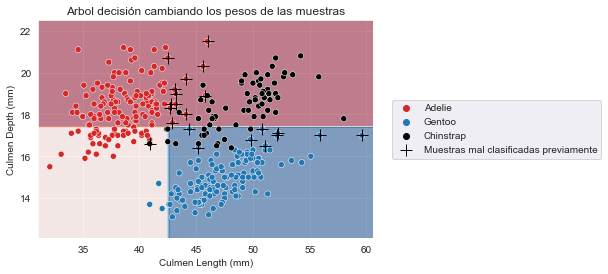

In [45]:
DecisionBoundaryDisplay.from_estimator(
    tree, X, response_method="predict", cmap="RdBu", alpha=0.5
)
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
sns.scatterplot(data=X_misclassified, x=culmen_columns[0],
                y=culmen_columns[1],
                label="Muestras mal clasificadas previamente",
                marker="+", s=150, color="k")

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Arbol decisión cambiando los pesos de las muestras")

Vemos que la función de decisión ha cambiado drásticamente. Cualitativamente vemos que los ejemplos que previamente estaban mal clasificados ahora son clasificados correctamente.

In [46]:
y_pred = tree.predict(X)
newly_misclassified_samples_idx = np.flatnonzero(y != y_pred)
remaining_misclassified_samples_idx = np.intersect1d(
    misclassified_samples_idx, newly_misclassified_samples_idx
)

print(f"Número de muestras mal clasificadas previamente y "
      f"todavía mal clasificadas: {len(remaining_misclassified_samples_idx)}")

Número de muestras mal clasificadas previamente y todavía mal clasificadas: 0


Sin embargo, estamos cometiendo errores en muestras bien clasificadas previamente. Por tanto, tenemos la intuición de que debemos ponderar las predicciones de cada clasificador de forma diferente, muy probablemente utilizando el número de errores que comete cada clasificador.

Entonces podríamos usar el error de clasificación para combinar ambos árboles.

In [47]:
ensemble_weight = [
    (y.shape[0] - len(misclassified_samples_idx)) / y.shape[0],
    (y.shape[0] - len(newly_misclassified_samples_idx)) / y.shape[0],
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

El primer clasificador tiene una precisión del 93,5% y el segundo una precisión de 69,2%. Por lo tanto, cuando predecimos una clase, debemos confiar un poco más en el primer clasificador que en el segundo. Podríamos usar estos valores de precisión para ponderar las predicciones de cada aprendiz.

Para resumir, boosting aprende varios clasificadores, cada uno de los cuales se enfocará más o menos en muestras específicas del dataset. Boosting es, por tanto, diferente de bagging: aquí nunca se remuestrea nuestro dataset, solo asignamos pesos diferentes al dataset original.

Boosting requiere alguna estrategia para combinar los aprendizes juntos:

+ necesita definir una forma de calcular los pesos que serán asignados a las muestras;
+ necesita asignar un peso a cada aprendiz al hacer predicciones.

De hecho, definimos un esquema realmente simple para asignar pesos a las muestras y pesos a los aprendices. Sin embargo, existen teorías estadísticas (como en AdaBoost) sobre cómo se deben calcular óptimamente estos pesos.

Usaremos el clasificador AdaBoots implementado en scikit-learn y revisaremos los clasificadores de árbol de decisión entrenados subyacentes.

In [48]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(base_estimator=base_estimator,
                              n_estimators=3, algorithm="SAMME",
                              random_state=0)
adaboost.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=0),
                   n_estimators=3, random_state=0)

<Figure size 432x288 with 0 Axes>

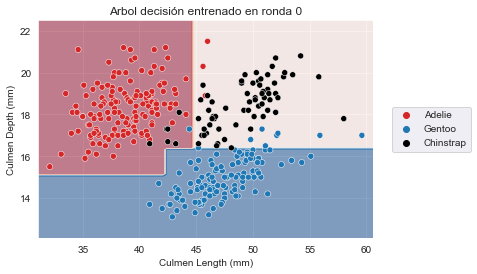

<Figure size 432x288 with 0 Axes>

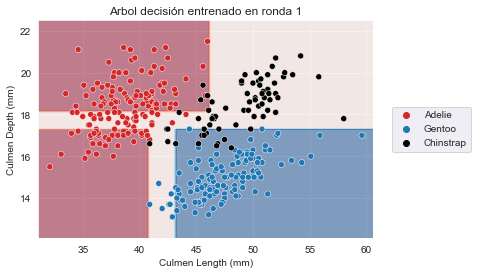

<Figure size 432x288 with 0 Axes>

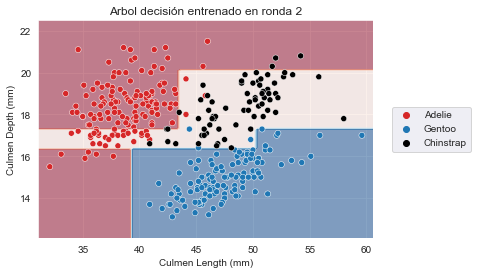

In [49]:
for boosting_round, tree in enumerate(adaboost.estimators_):
    plt.figure()
    # covertimos "X" en un array Numpy para eviar el warning lanzado por scikit-learn
    DecisionBoundaryDisplay.from_estimator(
        tree, X.to_numpy(), response_method="predict", cmap="RdBu", alpha=0.5
    )
    sns.scatterplot(x=culmen_columns[0], y=culmen_columns[1],
                    hue=target_column, data=penguins,
                    palette=palette)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    _ = plt.title(f"Arbol decisión entrenado en ronda {boosting_round}")

In [50]:
print(f"Peso de cada clasificador: {adaboost.estimator_weights_}")

Peso de cada clasificador: [3.58351894 3.46901998 3.03303773]


In [51]:
print(f"Error de cada clasificador: {adaboost.estimator_errors_}")

Error de cada clasificador: [0.05263158 0.05864198 0.08787269]


Vemos que AdaBoost ha aprendido tres clasificadores diferentes, cada uno de los cuales se enfoca en muestras diferentes. Revisando los pesos de cada aprendiz, vemos que el conjunto ofrece el mayor peso al primer clasificador. Esto de hecho tiene sentido cuando revisamos los errores de cada clasificador. El primer clasificador también obtiene la clasificación más alta en rendimiento de generalización.

Aunque que AdaBoost es un buen algoritmo para demostrar la maquinaria interna de los algoritmos de boosting, no es el más eficiente. Este título se otorga al algoritmo de árbol de decisión gradient-boosting (GBDT).

## Arbol de decisión gradient-boosting (GBDT)

Vamos a ver el algoritmo de árbol de decisión gradient boosting y lo compararemos con AdaBoost.

Gradient-boosting difiere de AdaBoost en lo siguiente: en lugar de asignar pesos a muestras específicas, GBDT entrenará un árbol de decisión en los errores residuales (de ahí el nombre "gradiente") del árbol anterior. Por lo tanto, cada nuevo árbol del conjunto predice el error cometido por el anterior en lugar de predecir directamente el objetivo.

Vamos a proporcionar algunas intuiciones sobre la forma en que se combinan los aprendices para proporcionar la predicción final.

In [52]:
import pandas as pd
import numpy as np

# Crea un generador de número aleatorio que utilizaremos para establecer la aleatoriedad
rng = np.random.RandomState(0)

def generate_data(n_samples=50):
    """Genera dataset sintético. Devuelve `X_train`, `X_test`,
    `y_train`."""
    x_max, x_min = 1.4, -1.4
    len_x = x_max - x_min
    x = rng.rand(n_samples) * len_x - len_x / 2
    noise = rng.randn(n_samples) * 0.3
    y = x ** 3 - 0.5 * x ** 2 + noise

    X_train = pd.DataFrame(x, columns=["Feature"])
    X_test = pd.DataFrame(np.linspace(x_max, x_min, num=300),
                             columns=["Feature"])
    y_train = pd.Series(y, name="Target")

    return X_train, X_test, y_train


X_train, X_test, y_train = generate_data()

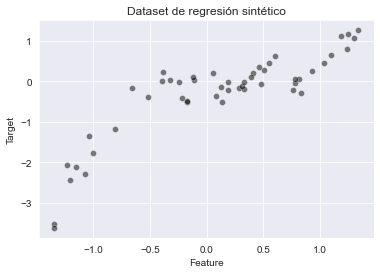

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
_ = plt.title("Dataset de regresión sintético")

Como vimos anteriormente, boosting se basa en ensamblar una secuencia de aprendices. Empezaremos creando un regresor de arbol de decisión. Estableceremos la profundidad del árbol para que el aprendiz resultante produzca underfitting.

In [54]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

Usamos el término "test" para referirnos a datos que no se han usado para el entrenamiento. No debemos confundirlo con datos provenientes de una división entrenamiento-prueba, ya que se generó en intervalos espaciados equitativamente para la evaluación visual de las predicciones.

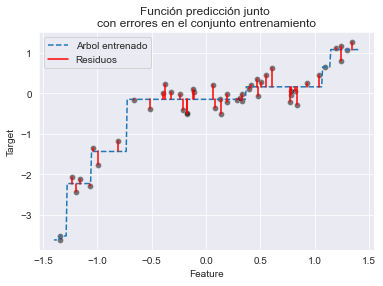

In [55]:
# dibuja los datos
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
# dibuja las predicciones
line_predictions = plt.plot(X_test["Feature"], y_test_pred, "--")

# dibuja los residuos
for value, true, predicted in zip(X_train["Feature"],
                                  y_train,
                                  y_train_pred):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Arbol entrenado", "Residuos"])
_ = plt.title("Función predicción junto \ncon errores en el conjunto entrenamiento")

Hemos editado manualmente la leyenda para obtener solo una única etiqueta para todas las líneas de residuos.

Dado que el arbol tiene underfit, su precisión está lejos de la perfección en los datos de entrenamiento. Podemos observar esto en el gráfico viendo las diferencias entre las predicciones y los datos reales. Estos errores, llamados residuos, se presentan mediante líneas rojas continuas.

De hecho, nuestro árbol inicial no era suficientemente expresivo para manejar la complejidad de los datos, como muestran los residuos. En un algoritmo grandient-boosting, la idea es crear un segundo árbol que, dados los mismos datos `X`, intentará predecir los residuos en lugar del vector `y`. Tendríamos, por tanto, un árbol que es capaz de predecir los errores que comete el árbol inicial.

Vamos a entrenar un árbol tal.

In [57]:
residuals = y_train - y_train_pred

tree_residuals = DecisionTreeRegressor(max_depth=5, random_state=0)
tree_residuals.fit(X_train, residuals)

target_train_predicted_residuals = tree_residuals.predict(X_train)
target_test_predicted_residuals = tree_residuals.predict(X_test)

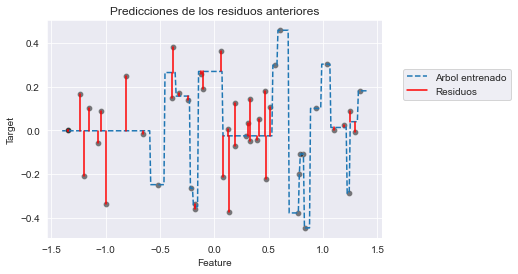

In [58]:
sns.scatterplot(x=X_train["Feature"], y=residuals, color="black", alpha=0.5)
line_predictions = plt.plot(
    X_test["Feature"], target_test_predicted_residuals, "--")

# dibuja los residuos de los residuos predichos
for value, true, predicted in zip(X_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Arbol entrenado", "Residuos"], bbox_to_anchor=(1.05, 0.8),
           loc="upper left")
_ = plt.title("Predicciones de los residuos anteriores")

Vemos que este nuevo árbol solo logra manejar algunos de los residuos. Nos enfocaremos en una muestra específica del conjunto de entrenamiento (es decir, sabemos que la muestra será bien predicha usando dos árbole sucesivos). Usaremos este ejemplo para explicar cómo se combinan las predicciones de ambos árboles. Primero seleccionaremos esta muestra en `X_train`.

In [59]:
sample = X_train.iloc[[-2]]
x_sample = sample['Feature'].iloc[0]
target_true = y_train.iloc[-2]
target_true_residual = residuals.iloc[-2]

Vamos a dibujar la información previa y destacaremos nuestra muestra. Empezaremos dibujando los datos original y la predicción del primer árbol de decisión.

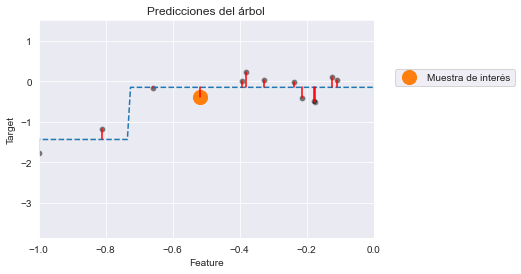

In [60]:
# Dibuja la información previa:
#   * el dataset
#   * las predicciones
#   * los residuos

sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
plt.plot(X_test["Feature"], y_test_pred, "--")
for value, true, predicted in zip(X_train["Feature"],
                                  y_train,
                                  y_train_pred):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Destacamos la muestra de interés
plt.scatter(sample, target_true, label="Muestra de interés",
            color="tab:orange", s=200)
plt.xlim([-1, 0])
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predicciones del árbol")

Ahora dibujaremos la información de los residuos. Dibujaremos los residuos calculados por el primer árbol de decisión y mostraremos las predicciones de residuos.

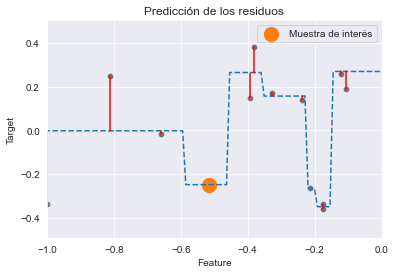

In [61]:
# Dibuja la información previa:
#   * los residuso cometidos por el primer árbol
#   * las predicciones de residuos
#   * los residuos de las predicciones de residuos

sns.scatterplot(x=X_train["Feature"], y=residuals,
                color="black", alpha=0.5)
plt.plot(X_test["Feature"], target_test_predicted_residuals, "--")
for value, true, predicted in zip(X_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Destaca la muestra de interés
plt.scatter(sample, target_true_residual, label="Muestra de interés",
            color="tab:orange", s=200)
plt.xlim([-1, 0])
plt.legend()
_ = plt.title("Predicción de los residuos")

Para nuestra muestra de interés, nuestro árbol inicial cometía un error (residuo pequeño). Cuando entrenamos el segundo árbol, en este caso el residuo se entrena y se predice perfectamente. Verificaremos cuantitativamente esta predicción usando el árbol entrenado. Primero, verificaremos la predicción de árbol inicial y compararemos con su valor real.

In [63]:
print(f"El valor real a predecir para "
      f"f(x={x_sample:.3f}) = {target_true:.3f}")

y_pred_first_tree = tree.predict(sample)[0]
print(f"Predicción del primer árbol de decisión para x={x_sample:.3f}: "
      f"y={y_pred_first_tree:.3f}")
print(f"Error del árbol: {target_true - y_pred_first_tree:.3f}")

El valor real a predecir para f(x=-0.517) = -0.393
Predicción del primer árbol de decisión para x=-0.517: y=-0.145
Error del árbol: -0.248


Como observamos visualmente, tenemos un pequeño error. Ahora, usaremos el segundo árbol para intentar predecir este residuo.

In [64]:
print(f"Predicción del residuo para x={x_sample:.3f}: "
      f"{tree_residuals.predict(sample)[0]:.3f}")

Predicción del residuo para x=-0.517: -0.248


Vemos que nuestro segundo árbol es capaz de predecir el residuo exacto (error) de nuestro primer árbol. Por tanto, podemos predecir el valor de `x` sumando la predicción de todos los árboles del conjunto.

In [65]:
y_pred_first_and_second_tree = (
    y_pred_first_tree + tree_residuals.predict(sample)[0]
)
print(f"Predicción del primer y segundo árbol de decisión combinados para "
      f"x={x_sample:.3f}: y={y_pred_first_and_second_tree:.3f}")
print(f"Error del árbol: {target_true - y_pred_first_and_second_tree:.3f}")

Predicción del primer y segundo árbol de decisión combinados para x=-0.517: y=-0.393
Error del árbol: 0.000


Elegimos una muestra para la cual solo fueron suficientes dos árboles para hacer una predicción perfecta. Sin embargo, vimos anteriormente en el gráfico anterior que dos árboles no son suficientes para corregir los residuos de todas las muestras. Por tanto, se necesita añadir varios árboles al conjunto para corregir adecuadamente el error (es decir, el segundo árbol corrige el error del primer árbol, mientras que el tercer árbol corrige los errores del segundo árbol y así sucesivamente).

Compararemos el rendimiento de generalización de random forest y gradient boosting en el dataset de propiedades de California.

In [66]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_validate

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
y *= 100  # reescala el objetivo a k$

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(n_estimators=200)
cv_results_gbdt = cross_validate(
    gradient_boosting, X, y, scoring="neg_mean_absolute_error",
    n_jobs=-1
)

In [69]:
print("Arbol decisión gradient boosting")
print(f"Error absoluto medio a través de validación cruzada: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{-cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Tiempo de entrenamiento medio: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Tiempo de puntuación medio: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Arbol decisión gradient boosting
Error absoluto medio a través de validación cruzada: 46.390 +/- -2.916 k$
Tiempo de entrenamiento medio: 6.407 seconds
Tiempo de puntuación medio: 0.008 seconds


In [70]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=200, n_jobs=-1)
cv_results_rf = cross_validate(
    random_forest, X, y, scoring="neg_mean_absolute_error",
    n_jobs=-1
)

In [71]:
print("Random forest")
print(f"Error absoluto medio a través de validación cruzada: "
      f"{-cv_results_rf['test_score'].mean():.3f} +/- "
      f"{-cv_results_rf['test_score'].std():.3f} k$")
print(f"Tiempo de entrenamiento medio: "
      f"{cv_results_rf['fit_time'].mean():.3f} seconds")
print(f"Tiempo de puntuación medio: "
      f"{cv_results_rf['score_time'].mean():.3f} seconds")

Random forest
Error absoluto medio a través de validación cruzada: 46.514 +/- -4.490 k$
Tiempo de entrenamiento medio: 8.851 seconds
Tiempo de puntuación medio: 0.387 seconds


En términos de rendimiento computacional, el bosque se puede paralelizar, beneficiándose del uso de múltiples cores de CPU. En términos de rendimiento de puntuación, ambos alboritmos conducen a resultados muy cercanos.

Sin embargo, vemos que gradient boosting es un algoritmo muy rápido para predecir comparado con random forest. Esto se debe al hecho de que gradient boosting usa árboles poco profundos.